# Comparison between solvers for systems of linear equations

Group project: I.M. de Oliveira and E. Brunn

APC523: Numerical Methods for Scientific Computing

Spring 2021

Prof. Hammett

## Import the required functions

(Note: The attempt of importing the files was unsuccessful using Jupyter lab in Windows, hence they are copied and pasted here).

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

def setup(G, force_x, force_y, elasticity, area):
    """
    Setup geometry, material, boundary conditions, loads, cross-section.
    """
    # define coordinate system
    x_axis = np.array([1.0, 0.0])
    y_axis = np.array([0.0, 1.0])

    # define model
    nodes = G.vertex_list

    list_dof = [[2*i + j for j in range(1,3)] for i in range(len(nodes))]
    list_nodes = list(nodes.keys())
    dof = dict(zip(list_nodes, list_dof))

    elements = G.edge_list

    restrained_dof = [1, 2, 3, 4] # supports at the first 2 nodes
    forces = dict(zip(nodes, [[0]* 2]*len(nodes)))
    forces[list_nodes[-1]] = [force_x, force_y] # force y direction at the last node

    # material properties [force/area]
    stiffnesses = dict(zip(elements, [elasticity]*len(elements))) # Steel [kN/cm2]

    # cross-section properties [area]
    areas = dict(zip(elements, [area]*len(elements))) # [cm2]

    ndof = 2 * len(nodes)

    return {'x_axis': x_axis, 'y_axis': y_axis, 'nodes': nodes,
            'dof': dof, 'elements': elements, 'restrained_dof': restrained_dof,
            'forces': forces, 'ndof': ndof, 'stiffnesses': stiffnesses,
            'areas': areas}

def plot_nodes(nodes):
    """
    Plot nodes with global enumeration.
    """
    x = [i[0] for i in nodes.values()]
    y = [i[1] for i in nodes.values()]
    size = 400
    offset = size/4000
    plt.scatter(x, y, c='b', s=size, zorder=5)

    for i, location in enumerate(zip(x, y)):
        plt.annotate(i+1, (location[0]-offset,  location[1]-offset), zorder=10)

def points(element, properties):
    """
    Get start and end points of an element, and respective degrees of freedom.
    """
    elements = properties['elements']
    nodes = properties['nodes']
    dof = properties['dof']

    # find nodes that elements connects
    start_node = elements[element][0]
    end_node = elements[element][1]

    # coordinates for each node
    start_pt = np.array(nodes[start_node])
    end_pt = np.array(nodes[end_node])

    # degrees of freedom for each node
    dof_ns = dof[start_node] # get the first 2 dof from start node
    dof_nodes = list(dof_ns)
    dof_nodes.extend(dof[end_node]) # add 2 dof from end node and flatten list
    dof_nodes = np.array(dof_nodes)

    return start_pt, end_pt, dof_nodes

def draw_element(start_pt, end_pt, element, areas):
    """
    Draw an element with linewidth proportional to it's cross-section area.
    """
    plt.plot([start_pt[0], end_pt[0]], [start_pt[1], end_pt[1]], color='k',
            linestyle='-', zorder=1) #arbitraty scale

def direction_cosine(vec1, vec2):
    """
    Get the direction cosine (the cosine of the angle between two vectors).
    """
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

def rotation_matrix(element_vec, x_axis, y_axis):
    """
    Rotation matrix of an element.
    """
    x_proj = direction_cosine(element_vec, x_axis)
    y_proj = direction_cosine(element_vec, y_axis)

    return np.array([[x_proj, y_proj, 0, 0], [0, 0, x_proj, y_proj]])

def get_matrices(properties):
    """
    """
    # construct the global stiffness matrix
    ndof = properties['ndof']
    nodes = properties['nodes']
    elements = properties['elements']
    forces = properties['forces']
    areas = properties['areas']
    x_axis = properties['x_axis']
    y_axis = properties['y_axis']

    plot_nodes(nodes)

    K = np.zeros((ndof, ndof))

    for element in elements:
        # find element geometry
        start_pt, end_pt, dof = points(element, properties)
        element_vec = end_pt - start_pt
        draw_element(start_pt, end_pt, element, areas)

        # local element stiffness matrix
        length = norm(element_vec)
        area = properties['areas'][element]
        E = properties['stiffnesses']

        c_k = E[element] * area / length

        # local k for a truss element
        k_element = np.array([[1, -1], [-1, 1]])

        # element rotation matrix
        q_element = rotation_matrix(element_vec, x_axis, y_axis)
        # apply rotation
        k_q = q_element.T.dot(k_element).dot(q_element)

        # connectivity matrix determines where k_element is added in the global
        # K matrix
        index = dof - 1
        connect = np.zeros((4, ndof)) # 4 is the number of dof for a truss element
        for i in range(4):
            connect[i, index[i]] = 1.0
        K_q = connect.T.dot(k_q).dot(connect)
        K += c_k * K_q

    # force vector R
    R = []
    for r in forces.values():
        R.extend(r)
    R = np.array(R)

    # remove restrained dof (the rows and cols of K we need to delete)
    remove_indices = np.array(properties['restrained_dof']) - 1
    for i in [0, 1]:
        K = np.delete(K, remove_indices, axis=i)

    R = np.delete(R, remove_indices)

    return K, R

def get_stresses(properties, u):
    """
    Stress in each element.
    """
    x_axis = properties['x_axis']
    y_axis = properties['y_axis']
    elements = properties['elements']
    E = properties['stiffnesses']

    # find stresses in each element in local coord.
    stresses = []
    for element in elements:
        # find element geometry
        start_pt, end_pt, _ = points(element, properties)
        element_vec = end_pt - start_pt

        # element rotation matrix
        q_element = rotation_matrix(element_vec, x_axis, y_axis)
        u_global = np.array([0, 0, u[0], u[1]]) # only axial displacements
        u_element = q_element.dot(u_global)

        strain = (u_element[1] - u_element[0]) / norm(element_vec)
        stress = E[element] * strain
        stresses.append(stress)

    return stresses

def show_results(u, stresses, area):
    """
    Prints the nodal displacements, stresses and maximum displacement magnitude.
    """
    print("Nodal Displacements:", np.round(u, 5))
    print("Stresses:", np.round(stresses, 2))
    force = np.round(stresses, 2) * area
    print("Normal Forces:", np.round(force, 2))
    print("Displacment Magnitude:", round(norm(u), 5))
    print("\n")

In [2]:
#PYTHON IMPORTS
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

from scipy.spatial import ConvexHull, convex_hull_plot_2d

class Graph():

    def __init__(self, vertex_list, edge_list, rigid_edge = None, edge_lengths = False):
        
        self.dim = 2

        self.vertex_list = vertex_list
        self.edge_list = edge_list   

        if rigid_edge is None:
            self.rigid_edge = None
            self.ridid_node = None
        else:
            self.rigid_edge = rigid_edge
            self.rigid_node = np.array([val for key,val in self.edge_list.items() if key in self.rigid_edge]).flatten()

        self.G = self.create_graph()

        if edge_lengths:
            self.lengths = {values:edge_lengths[keys] for keys,values in edge_list.items()}
        else:
            self.lengths = self.calc_edge_len()

    def create_graph(self):
        g = nx.Graph()

        g.add_nodes_from(self.vertex_list.keys())
        g.add_edges_from(self.edge_list.values())

        for n, p in self.vertex_list.items():
            g.nodes[n]['pos'] = p

        return g

    def calc_edge_len(self):
        lengths={}
        for edge in self.edge_list.values():
            start = np.array(self.vertex_list[edge[0]])
            end = np.array(self.vertex_list[edge[1]])

            lengths[edge] = np.linalg.norm(start-end)
        
        return lengths


def generate_graph(n = 10, fac = 1):

    """generate a random graph but start with a triangle"""

    points = {
        0: (0,0),
        1: (3,0),
        2: (1.5,1.5),
        }

    edges = {
        0: (0,1),
        1: (0,2),
        2: (1,2),
        }

    for i in range(3,n):
        new_pnt = (round(random.random()*fac,1),round(random.random()*fac,1))
        points[i] = new_pnt

        l = [*range(0,i)]
        new_edges = random.sample(l,2)

        edges[len(edges)] = (i,new_edges[0])
        edges[len(edges)] = (i,new_edges[1])

    return points, edges

def generate_graph_guess(n, vertex_list, fac = 1):

    points = {
        0: vertex_list[0],
        1: vertex_list[1],
    }

    for i in range(2,n):
        new_pnt = (round(random.random()*fac,1),round(random.random()*fac,1))
        points[i] = new_pnt

    return points

## Generate graphs

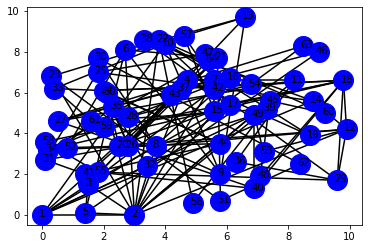

In [3]:
# external dependencies
from numpy.linalg import inv
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.sparse.linalg import dsolve
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg

#PYTHON IMPORTS
import random

##########################################################
# 1. Create target structure and properties.
##########################################################
random.seed(12)

##########################################################
# 1.1. CHANGE NUMBER OF NODES
##########################################################
gen_size = 64 # Variations: 16, 32, 64, 128, 256, 512

vertices, edges = generate_graph(n = gen_size, fac = 10)

# meters
G1 = Graph(vertex_list = vertices, edge_list = edges)

force_x = 0 # kN
force_y = -1000 # kN
elasticity = 205e6 # kN/m2
area = 0.1 * 0.1 # m2

##########################################################
# 2. Set up the problem without solving [K]{u} = {R}.
##########################################################

# problem setup
properties = setup(G1, force_x, force_y, elasticity, area)

# determine global matrices
K, R = get_matrices(properties)

## Solve [K]{u} = {R} using different solvers

## Numpy inv

This is the method that was used to validate the structural model outputs.

In [4]:
%%timeit
u = inv(K).dot(R)

332 µs ± 41.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
u = inv(K).dot(R)

## SciPy's LU Decomposition

The scipy.linalg.solve_lu function calls LAPACK and uses the double getrs FORTRAN function.


In [6]:
from scipy.linalg import lu_factor, lu_solve
# with scipy lu decomposition

In [7]:
%%timeit
lu, piv = lu_factor(K)
u_lu = lu_solve((lu, piv), R)

130 µs ± 6.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Verify result with validated inv method.

In [8]:
lu, piv = lu_factor(K)
u_lu = lu_solve((lu, piv), R)
np.allclose(u, u_lu)

True

# SciPy's Biconjugate Gradient

In [9]:
from scipy.sparse.linalg import bicg

In [10]:
%%timeit
u_bicg, exit_bicg = bicg(K, R, atol=1e-10, maxiter=1e6)

36.2 ms ± 4.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
def solve_bicg(A, b):
    num_iters = 0

    def callback(xk):
        nonlocal num_iters
        num_iters+=1

    x, exitcode = bicg(A, b, tol=1e-10, maxiter=1e6, callback=callback)
    return x, exitcode, num_iters

In [12]:
u_bicg, exit_bicg, iter_bicg = solve_bicg(K, R)

print('Exit code: ', exit_bicg)
print('All close: ', np.allclose(u, u_bicg, atol=1e-2))
print('Iterations: ', iter_bicg)

Exit code:  0
All close:  True
Iterations:  420


## SciPy's GMRES

In [13]:
from scipy.sparse.linalg import gmres

In [14]:
%%timeit
u_gmres, exit_gmres = gmres(K, R, tol=1e-10, restart=60, maxiter=1e6)

2.97 s ± 146 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
def solve_gmres(A, b):
    num_iters = 0

    def callback(xk):
        nonlocal num_iters
        num_iters+=1

    x, exitcode = gmres(A, b, tol=1e-10, restart=60, maxiter=1e6, callback=callback)
    return x, exitcode, num_iters

In [16]:
u_gmres, exit_gmres, iter_gmres = solve_gmres(K, R)

print('Exit code: ', exit_gmres)
print('All close: ', np.allclose(u, u_gmres, atol=1e-2))
print('Iterations: ', iter_gmres)

Exit code:  0
All close:  True
Iterations:  64385
